<a href="https://colab.research.google.com/github/evolver16/42pro/blob/main/Advanced02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving climate.csv to climate.csv


In [18]:
# import required libraries
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
# Determine device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Clear CUDA cache if using CUDA
if device == 'cuda':
    torch.cuda.empty_cache()
    print("CUDA memory cache cleared.")

Using device: cuda
CUDA memory cache cleared.


In [11]:
# Read the data from the CSV file
df = pd.read_csv("climate.csv")

# Display the first few rows of the dataframe to inspect the data
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wind x,Wind y,max Wind x,max Wind y,Day sin,Day cos,Year sin,Year cos
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


In [12]:
# Generate descriptive statistics of the DataFrame
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wind x,Wind y,max Wind x,max Wind y,Day sin,Day cos,Year sin,Year cos
count,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,7.009100e+04,7.009100e+04,70091.000000,70091.000000
mean,989.212842,9.450482,283.493086,4.956471,76.009788,13.576576,9.533968,4.042536,6.022560,9.640437,1216.061232,-0.627813,-0.407068,-1.018681,-0.733589,-6.083156e-05,-1.428652e-04,0.001614,-0.000672
std,8.358886,8.423384,8.504424,6.730081,16.474920,7.739883,4.183658,4.898549,2.655812,4.234862,39.974263,1.987440,1.552621,3.095279,2.611890,7.070992e-01,7.071245e-01,0.706813,0.707408
min,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.810000,0.000000,0.510000,0.810000,1059.450000,-11.305514,-8.274385,-19.641473,-14.883367,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000
25%,984.200000,3.350000,277.440000,0.240000,65.210000,7.770000,6.220000,0.870000,3.920000,6.290000,1187.470000,-1.470727,-1.364699,-2.469210,-2.322709,-7.071068e-01,-7.071068e-01,-0.704504,-0.708115
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,-0.633142,-0.293467,-1.117029,-0.527021,1.321740e-14,-9.732065e-15,0.003316,-0.001122
75%,994.720000,15.480000,289.530000,10.080000,89.400000,17.610000,12.360000,5.300000,7.800000,12.490000,1242.765000,0.299975,0.450077,0.627619,0.822895,7.071068e-01,7.071068e-01,0.708301,0.707423
max,1015.290000,37.280000,311.210000,23.060000,100.000000,63.770000,28.250000,46.010000,18.070000,28.740000,1393.540000,8.244699,7.733831,11.913133,14.302308,1.000000e+00,1.000000e+00,1.000000,1.000000


In [30]:
# Convert the 'Date Time' column to datetime format
df['Date Time'] = pd.to_datetime(df['Date Time'],dayfirst=True)

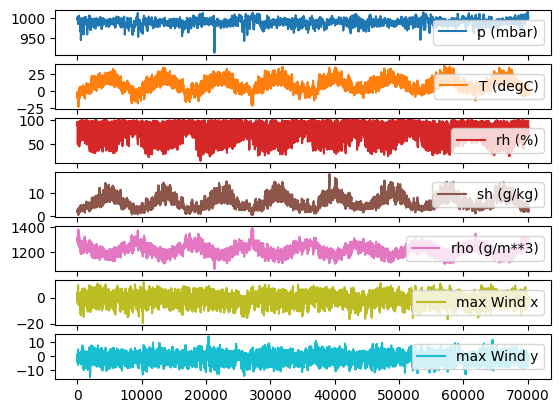

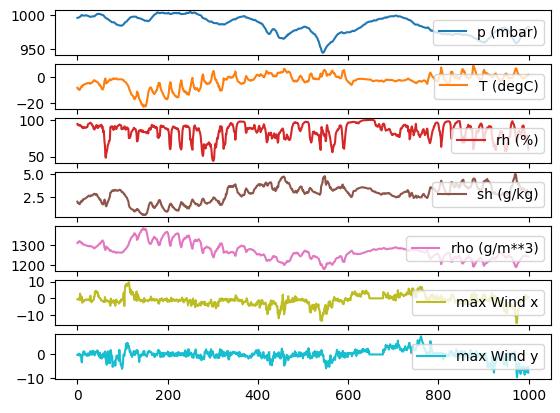

In [26]:
class ClimateDataVisualizer:
    def __init__(self, data_frame):
        self.df = data_frame

    def plot_features(self, columns, num_rows=None):
        """
        Plot the specified columns from the DataFrame.

        Args:
            columns (list): List of column names to plot.
            num_rows (int, optional): Number of rows to limit the plot to. Default is None (use all rows).

        Returns:
            None
        """
        colors = cm.tab10(np.linspace(0, 1, len(columns)))
        plt.figure()
        for i, (col,color) in enumerate(zip(columns,colors)):
            plt.subplot(len(columns), 1, i + 1)
            if num_rows is not None:
                plt.plot(self.df[col][:num_rows],color=color,label=col)
            else:
                plt.plot(self.df[col],color=color,label=col)
            plt.legend(loc='right')

        plt.show()

# Create an instance of the ClimateDataVisualizer class
visualizer = ClimateDataVisualizer(df)

# Define the columns to be plotted
columns_to_plot = ['p (mbar)', 'T (degC)', 'rh (%)', 'sh (g/kg)', 'rho (g/m**3)', 'max Wind x', 'max Wind y']

# Plot the specified columns with the option to limit the number of rows
visualizer.plot_features(columns_to_plot)
visualizer.plot_features(columns_to_plot, num_rows=1000)

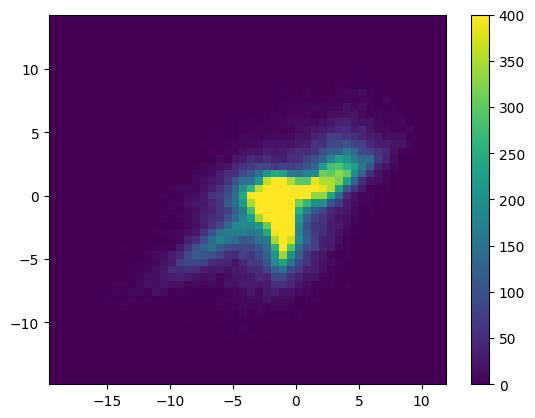

In [27]:
class WindHistogramPlotter:
    def __init__(self, data_frame):
        self.df = data_frame

    def plot_wind_histogram(self):
        """
        Create a 2D histogram plot for two columns of the DataFrame.

        Args:
            x_col (str): The name of the column for the x-axis.
            y_col (str): The name of the column for the y-axis.
            bins (tuple, optional): Number of bins for x and y axes. Default is (50, 50).
            vmax (int, optional): Maximum value for color scale. Default is 400.

        Returns:
            None
        """
        plt.figure()
        plt.hist2d(self.df['max Wind x'], self.df['max Wind y'], bins=(50, 50), vmax=400)
        plt.colorbar()

wind_plotter = WindHistogramPlotter(df)
wind_plotter.plot_wind_histogram()
plt.show()

In [43]:
# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, shuffle=False)

In [44]:
# Normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std

/tmp/ipython-input-44-1145706392.py:5: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  train_df = (train_df - train_mean) / train_std
/tmp/ipython-input-44-1145706392.py:6: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  val_df = (val_df - train_mean) / train_std


/tmp/ipython-input-45-2801925870.py:18: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  normalized_df = (self.df - self.train_mean) / self.train_std


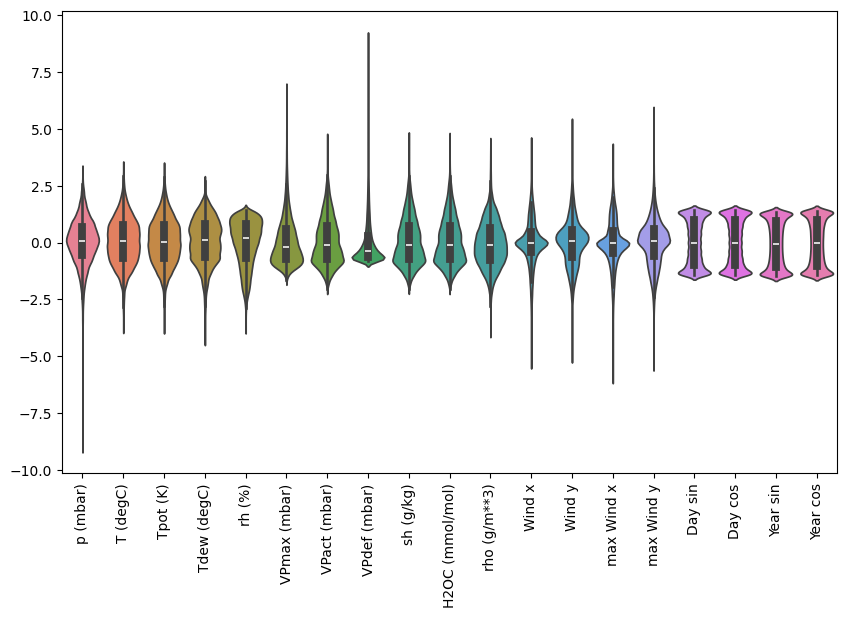

In [45]:
class DataVisualizer:
    def __init__(self, df, train_mean, train_std):
        self.df = df
        self.train_mean = train_mean
        self.train_std = train_std

    def normalize_and_plot(self):
        """
        Normalize the DataFrame and create a violin plot for visualization.

        Args:
            None

        Returns:
            None
        """
        # Normalize the DataFrame
        normalized_df = (self.df - self.train_mean) / self.train_std
        normalized_df = normalized_df.drop(columns=['Date Time'])
        # Create a violin plot
        plt.figure(figsize=(10, 6))
        sns.violinplot(data=normalized_df)
        plt.xticks(rotation=90)

visualizer = DataVisualizer(df, train_mean, train_std)
visualizer.normalize_and_plot()

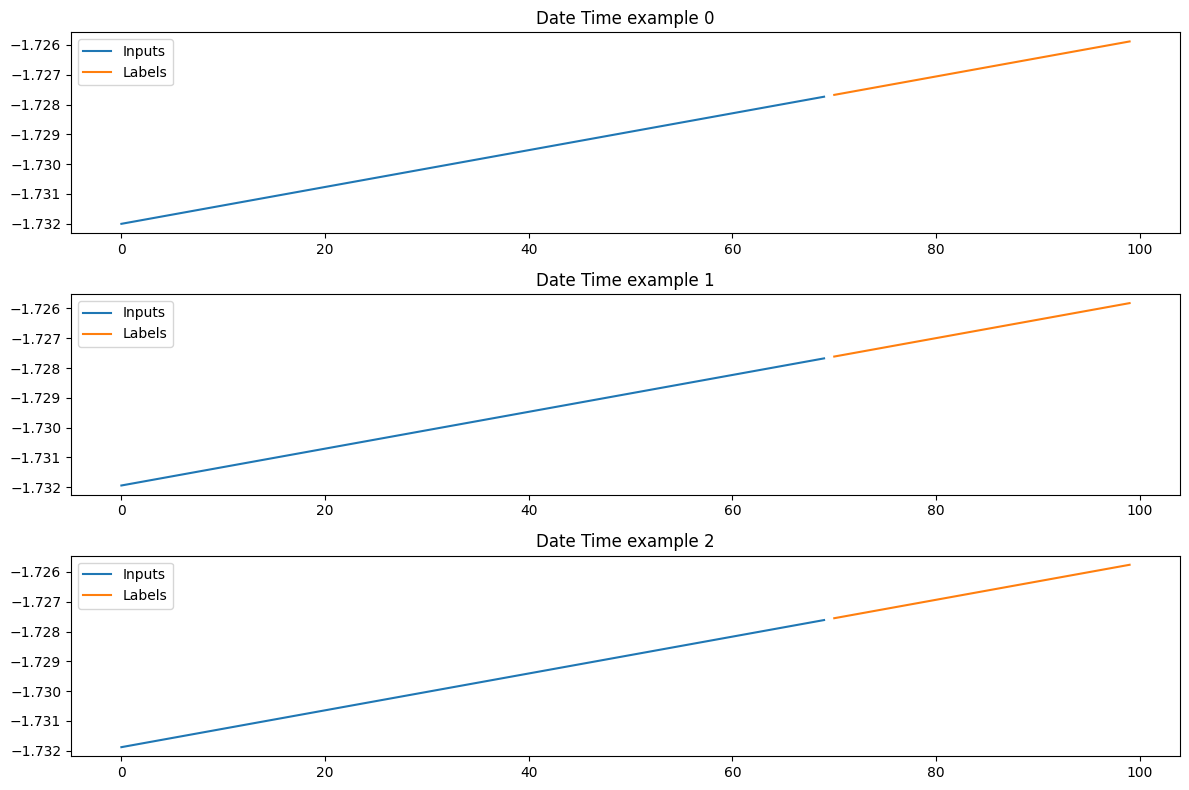

In [46]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, label_columns=None):


  def __repr__(self):
import matplotlib.pyplot as plt
import numpy as np

class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.label_columns = label_columns

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        # Column indices for labels if provided
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        else:
            self.label_columns_indices = None

        # Map all columns to indices
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Slices for inputs and labels
        self.input_slice = slice(0, input_width)
        self.label_start = self.total_window_size - label_width
        self.label_slice = slice(self.label_start, self.label_start + label_width)

    def __repr__(self):
        return (f'WindowGenerator(input_width={self.input_width}, label_width={self.label_width}, shift={self.shift}, '
                f'label_columns={self.label_columns})')

    def plot(self, model=None, plot_col=None, max_subplots=3):
        """
        Plot input and label windows for a few samples.
        Optionally plot model predictions if model is provided.
        """
        plt.figure(figsize=(12, 8))
        plot_col = plot_col or self.train_df.columns[0]

        for i in range(min(max_subplots, len(self.train_df) - self.total_window_size)):
            # Extract input and label slices for this example
            input_start = i
            input_end = i + self.input_width
            label_start = i + self.total_window_size - self.label_width
            label_end = label_start + self.label_width

            inputs = self.train_df.iloc[input_start:input_end]
            labels = self.train_df.iloc[label_start:label_end]

            plt.subplot(max_subplots, 1, i+1)
            plt.plot(range(self.input_width), inputs[plot_col], label='Inputs')
            plt.plot(range(self.input_width, self.input_width + self.label_width), labels[plot_col], label='Labels')

            if model is not None:
                # You would implement model prediction logic here if desired
                pass

            plt.title(f'{plot_col} example {i}')
            plt.legend()

        plt.tight_layout()
        plt.show()


# Create an instance of WindowGenerator and call the plot method
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=70, label_width=OUT_STEPS, shift=OUT_STEPS, train_df=train_df, val_df=val_df)
multi_window.plot()

In [ ]:
# Maximum number of training epochs
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    """
    Compile and fit a TensorFlow model with early stopping.

    Args:
        model (tf.keras.Model): The TensorFlow model to compile and fit.
        window (WindowGenerator): The window generator for creating datasets.
        patience (int, optional): Number of epochs with no improvement after which training will be stopped.
                                   Default is 2.

    Returns:
        tf.keras.callbacks.History: Training history.
    """
    ...


655/655 [==============================] - 9s 14ms/step - loss: 0.2327 - mean_absolute_error: 0.3009


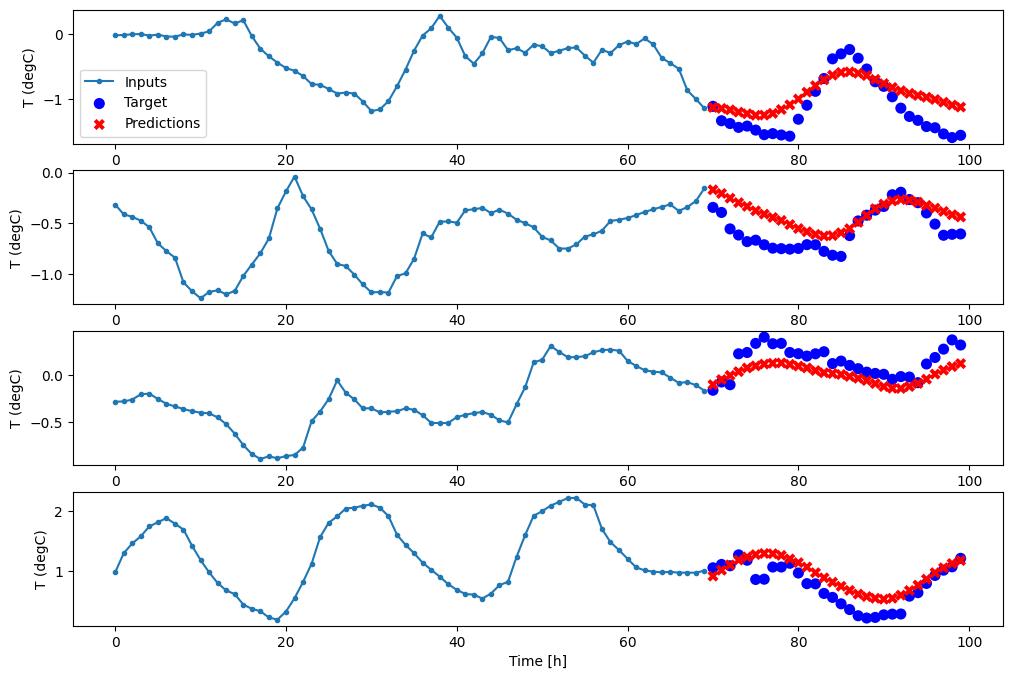

In [ ]:
# Define a multi-layer LSTM model
multi_lstm_model = ...

...

# Plot the model's predictions
multi_window.plot(multi_lstm_model)

In [ ]:
# Make predictions using the multi-layer LSTM model on the validation data
...

655/655 [==============================] - 11s 15ms/step


In [ ]:
# Denormalize model predictions
...

# Denormalize true test values
...